# Ermine Tutorial 02
## Jump-distance mixture modeling of single-particle tracking data with ermine

by Sebastian Malkusch (c) 2021  
malkusch@med.uni-frankfurt.de  
Data Science| Klinische Pharmakologie  
Institut für Klinische Pharmakologie  
Goethe - Universität  
Theodor-Stern-Kai 7  
60590 Frankfurt am Main

## Prerequisite
* Tutorial 01 must be completed
* The file Fab_CS6_cell20_jumps.csv needs to be saved in folder results

## Import libraries
You need to install Ermine prior to usage.  
Run  
python -m pip install git+https://github.com/SMLMS/pyErmine  
from the command line  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import ermine as em
from matplotlib import pyplot as plt

## Import Jump_df
Store the path to the jump data set in the variable "file_name"
The routine imports the jump data to a data frame (data_df).

In [2]:
file_name = "results/Fab_CS6_cell20_jumps.csv"
data_df = pd.read_csv(filepath_or_buffer = file_name)
data_df.head()

,Unnamed: 0,id_departure,frame_departure,x [nm]_departure,y [nm]_departure,sigma [nm]_departure,intensity [photon]_departure,offset [photon]_departure,bkgstd [photon]_departure,uncertainty_xy [nm]_departure,...,seg.id_destination,seg.loc_count_destination,seg.track_pos_destination,track.noise_destination,track.t_start_destination,track.lifetime_destination,track.id_destination,track.loc_count_destination,track.seg_count_destination,jump_distance
0,0,149,1,31496.6,32117.6,167.4,665.8,34.8,9.3,22.5,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,13.285330
1,1,357,2,31489.3,32106.5,168.6,916.5,33.0,10.8,19.2,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,7.964923
2,2,570,3,31496.3,32110.3,151.3,860.2,38.8,8.0,14.1,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,50.420631
3,3,783,4,31470.3,32067.1,182.5,594.9,32.0,7.3,24.0,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,26.654268
4,4,996,5,31472.0,32093.7,182.9,630.6,31.6,9.5,27.6,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,57.015437


## Screen for optimal model parameters
The routine trains multiple models and evaluates the model quality by means of log Likelihood, BIC, AIC and AICc.

In [3]:
seed  = 42
np.random.seed(seed)
x = data_df["jump_distance"].values

jmm = em.JumpDistanceMixtureModel(n_components=1,
                                  degrees_of_freedom = 4,
                                  tau = 0.02,
                                  init_params = "wm",
                                  params = "wm")
jmm.fit(x)
model_df = pd.DataFrame(jmm.evaluate(x))
for i in np.arange(start=2, stop=6, step=1):
    jmm = em.JumpDistanceMixtureModel(n_components=i,
                                      degrees_of_freedom = 4,
                                      tau = 0.02,
                                      init_params = "wm",
                                      params = "wm")
    jmm.fit(x)
    model_df = model_df.append(pd.DataFrame(jmm.evaluate(x)))
        
model_df

,classes,dof,instances,log_likelihood,BIC,AIC,AICc
0,1,1,130621,-695942.642841,1.391897e+06,1.391887e+06,1.391887e+06
0,2,3,130621,-687172.149107,1.374380e+06,1.374350e+06,1.374350e+06
0,3,5,130621,-686949.356781,1.373958e+06,1.373909e+06,1.373909e+06
0,4,7,130621,-686949.305839,1.373981e+06,1.373913e+06,1.373913e+06
0,5,9,130621,-686952.643902,1.374011e+06,1.373923e+06,1.373923e+06


## Identify optimal model by BIC
Plots the BIC and idententifies the optimal model

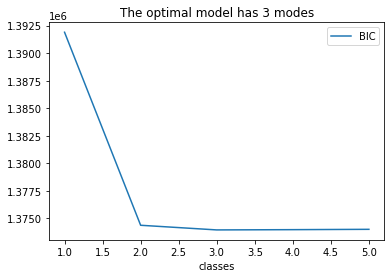

In [4]:
optModel_idx = np.argmin(model_df["BIC"].values)
optModel_components = model_df["classes"].values[optModel_idx]
model_df.plot.line(x="classes", y="BIC")
plt.title(str("The optimal model has %i modes" %(optModel_components)))
plt.show()

## Train optimal Model
Parameterize the optimal model by training with the jump distance sequence.
Store the optimized model parameters to optModel_diffusion_coefficients and optModel_weights.

In [5]:
x = data_df["jump_distance"].values
jmm = em.JumpDistanceMixtureModel(n_components = optModel_components,
                                  degrees_of_freedom = 4,
                                  tau = 0.02,
                                  init_params = "wm",
                                  params = "wm")
jmm.fit(x)
optModel_diffusion_coefficients = jmm.diffusion_coefficients()
optModel_weights = jmm._weights
print("done.")

done.


## Plot optimal model
plot the optimal model and superimpose it to the pdf of the original jumpdistance distribution.

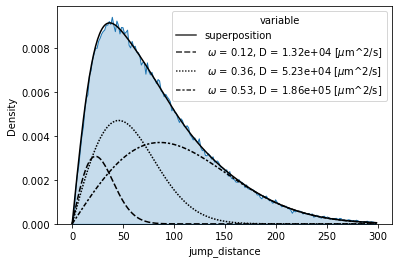

In [6]:
model_df = pd.DataFrame({"r": np.arange(0,300,1),
                        "superposition": np.zeros(300)})
for i in np.arange(0, optModel_components, 1):
    unimodal_judi_model = em.JumpDistanceModel(diffusion_coefficient = optModel_diffusion_coefficients[i],
                                               degrees_of_freedom = 4,
                                               tau=0.02)
    component_string = str(" $\\omega$ = %.2f, D = %.2e [$\\mu$m^2/s]" %(optModel_weights[i], optModel_diffusion_coefficients[i]))
    model_df[component_string] = optModel_weights[i] * unimodal_judi_model.pdf(distance = model_df["r"])
    model_df["superposition"] = model_df["superposition"] + model_df[component_string]

sns.kdeplot(data=data_df, x="jump_distance", fill = True, bw_adjust = 0.1, clip = [0, 300])
sns.lineplot(data=model_df.melt(id_vars=['r']), x="r", y="value", color="black", style="variable")
plt.show()